In [1]:
import oommfc as oc
import discretisedfield as df
%matplotlib inline

# Tutorial 2 - Hamiltonian

The energy of a magnetic system can be computed using Hamiltonian, which consists of different energy terms. In addition, the effective field which affects the magnetisation dynamics in the LLG equation (see [dynamics tutorial](tutorial3_dynamics.ipynb)) is also computed from the system's Hamiltonian.

In this tutorial, we explore different energy terms that can occur in the Hamiltonian.

## Zeeman energy

The Zeeman energy tends to align all magnetic moments parallel to the external magnetic field $\mathbf{H}$, so that the energy density $w_\text{z} = -\mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H}$ is minimum, where $\mu_{0}$ is the magnetic constant and $M_\text{s}$ is the magnetisation saturation.

To demonstrate the effect of Zeeman energy we will apply an external magnetic field $H = 10^{6} \,\text{A}\,\text{m}^{-1}$ in the positive $z$ direction to the one-dimensional array of magnetic moments. For the initial magnetisation configuration, we will take the $(1, 0, 1)$ direction with $M_\text{s} = 8 \times 10^{6} \,\text{A}\,\text{m}^{-1}$. 

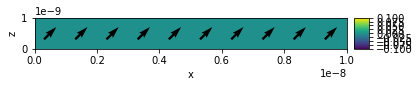

In [2]:
p1 = (0, 0, 0)
p2 = (10e-9, 1e-9, 1e-9)
cell = (1e-9, 1e-9, 1e-9)
mesh = oc.Mesh(p1=p1, p2=p2, cell=cell)

system = oc.System(name="zeeman")  # create the (micromagnetic) system object

H = (0, 0, 1e6)  # external magnetic field (A/m)
Ms = 8e6  # saturation magnetisation (A/m)
system.hamiltonian = oc.Zeeman(H=H)  # define system's Hamiltonian
system.m = df.Field(mesh, value=(1, 0, 1), norm=Ms)  # define initial magnetisation

system.m.plot_plane("y")

After we defined our system, we can minimize its energy using `MinDriver`.

2018/07/09 20:37: Running OOMMF (zeeman/zeeman.mif) ... (1.6 s)


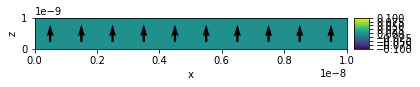

In [3]:
md = oc.MinDriver()  # create energy minimisation driver
md.drive(system)  # run energy minimisation

system.m.plot_plane("y")

We can see that after applying the magnetic field, all magnetic moments align parallel to $\mathbf{H}$.

### Exercise 1

Change the direction of applied field to be in the negative $x$ direction and inspect the minimum magnetisation state.

2018/07/09 20:37: Running OOMMF (zeeman/zeeman.mif) ... (1.6 s)


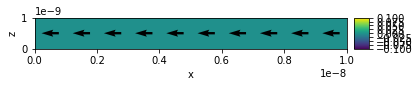

In [4]:
system.hamiltonian.zeeman.H = (-1e6, 0, 0)
md.drive(system)
system.m.plot_plane("y")

## Uniaxial anisotropy

Uniaxial anisotropy energy tends to align magnetic moments to be on the anisotropy axis either parallel or antiparallel without a preferred direction. Its energy density is $w_\text{a} = -K(\mathbf{m} \cdot \mathbf{u})^{2}$, where $K$ is the anisotropy constant and $\mathbf{u}$ is the anisotropy axis.

Let's assume our anisotropy axis is in the $(1, 0, 1)$ direction with $K = 6 \times 10^{6} \,\text{J}\,\text{m}^{-3}$ and the initial magnetisation is defined as

$$\mathbf{m} = \begin{cases} (-1, 0, -0.1) & \text{for } x \le 5 \,\text{nm} \\ (1, 0, 0.1) & \text{for } x > 5 \,\text{nm} \end{cases}$$

with $M_\text{s} = 8 \times 10^{6} \,\text{A}\,\text{m}^{-1}$.

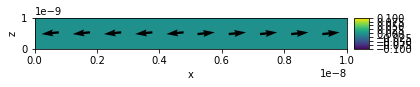

In [5]:
system = oc.System(name="uniaxial_anisotropy")
system.hamiltonian = oc.UniaxialAnisotropy(K1=6e6, u=(1, 0, 1))

def m_initial(pos):
    x, y, z = pos
    if x <= 5e-9:
        return (-1, 0, -0.1)
    else:
        return (1, 0, 0.1)

system.m = df.Field(mesh, value=m_initial, norm=Ms)

system.m.plot_plane("y")

We can now relax the magnetisation.

2018/07/09 20:37: Running OOMMF (uniaxial_anisotropy/uniaxial_anisotropy.mif) ... (1.6 s)


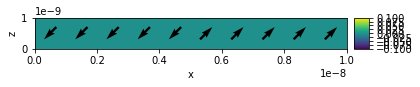

In [6]:
md.drive(system)
system.m.plot_plane("y")

We see that in the relaxed state, all magnetic moments are aligned with the aniostropy axis. The initial configuration affects which orientation along the anisotropy direction is chosen. 

## Exchange energy

The Zeeman and uniaxial anisotropy are *local* energy terms; they only depend on the magnetisation at a given location. In contrast, the exchange energy represents a short range interaction and tends to align all spins parallel to each other without a preferential direction. 

The exchange energy density is $w_\text{ex} = A[(\nabla m_{x})^{2} + (\nabla m_{y})^{2} + (\nabla m_{z})^{2}]$, where $A$ is the exchange energy constant. To demonstrate how it affects the magnetisation configuration, we will use $A = 8 \,\text{pJ}\,\text{m}^{-1}$ on a non-uniform magnetisation configuration.

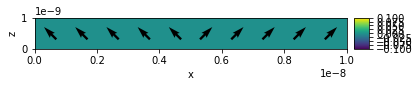

In [7]:
system = oc.System(name="exchange")
system.hamiltonian = oc.Exchange(A=8e-12)

def m_initial(pos):
    x, y, z = pos
    if x <= 5e-9:
        return (-1, 0, 1)
    else:
        return (1, 0, 1)
    
system.m = df.Field(mesh, value=m_initial, norm=Ms)

system.m.plot_plane("y")

2018/07/09 20:37: Running OOMMF (exchange/exchange.mif) ... (1.7 s)


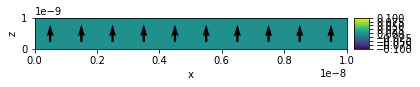

In [8]:
md.drive(system)
system.m.plot_plane("y")

## Dzyaloshinkii-Moriya energy

While the exchange interaction aims to align (neighbouring) magnetic moments parallel to each other, the Dzyaloshinskii-Moriya (DM) energy wants to align them perpendicular to each other.

The (interfacial) DMI energy density is $w_\text{dmi} = D[m_{z}\nabla\cdot\mathbf{m} - (\mathbf{m}\cdot\nabla)m_{z}]$, with $D$ being the DM constant. Again, we demonstrate its effect by starting from a uniform configuration, with $D = 3\times10^{3} \,\text{J}\,\text{m}^{-2}$.

2018/07/09 20:37: Running OOMMF (dmi/dmi.mif) ... (1.7 s)


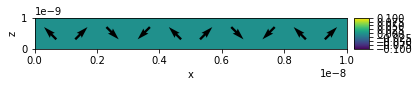

In [9]:
system = oc.System(name="dmi")
system.hamiltonian = oc.DMI(crystalclass="cnv", D=3e-3)
system.m = df.Field(mesh, value=(0, 0, 1), norm=Ms)

md.drive(system)

system.m.plot_plane("y")

## Exchange and Zeeman energies

So far, we investigated the effect of individual energy terms in the Hamiltonian. Now, we look at how multiple energies in the Hamiltoninan contribute to the final magnetisation configuration. We start with the simplest example where only exchange and Zeeman energies are present. As we showed before, exchange energy wants to align all magnetic moments parallel to each other without a preferential direction, while Zeeman energy wants them to be parallel to the external magnetic field. Therefore, we can expect that the minimum energy configuration is going to be the uniform state in the direction of an applied field $\mathbf{H}$.

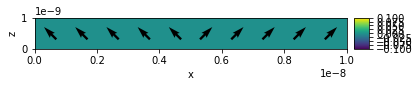

In [10]:
system = oc.System(name="exchange_and_zeeman")

# We can add multiple interactions using the 'plus' operator
system.hamiltonian = oc.Exchange(A=8e-12) + oc.Zeeman(H=(0, 0, -1e6))

def m_initial(pos):
    x, y, z = pos
    if x <= 5e-9:
        return (-1, 0, 1)
    else:
        return (1, 0, 1)
    
system.m = df.Field(mesh, value=m_initial, norm=Ms)

system.m.plot_plane("y")

2018/07/09 20:37: Running OOMMF (exchange_and_zeeman/exchange_and_zeeman.mif) ... (1.5 s)


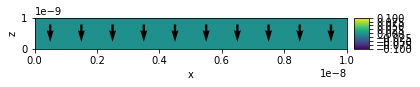

In [11]:
md.drive(system)
system.m.plot_plane("y")

Both energies are minimal in the above relaxed state: the magnetisation is uniform (minimising the exchange energy) and is aligned with the external field (minimising the Zeeman energy).

## Competition of DMI and exchange

Here, we study the competition of the exchange and (interfacial) DMI energy.

### Exercise 2

Relax a one-dimensional chain of magnetic moments of length $L = 20 \,\text{nm}$ with discretisation cell size of $(d, d, d)$, with $d = 1 \,\text{nm}$. The Hamiltonian should consist of:

- exchange energy with $A=1 \times 10^{-11} \,\text{J}\,\text{m}^{-1}$, and
- Dzyaloshinskii-Moriya energy with $D = 4\pi A/L \approx 6.28 \times 10^{-3} \,\text{J}\,\text{m}^{-2}$.

The magnetisation saturation is $M_\mathrm{s} = 8 \times 10^{6} \,\text{A}\,\text{m}^{-1}$.
Initialise the system with any uniform state. 

Questions:
- What is the relaxed state? 
- Double the value of DMI constant to be $D = 12.56 \times 10^{3} \,\text{J}\,\text{m}^{-2}$. What has changed?

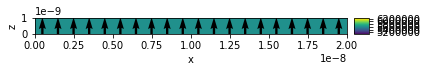

In [12]:
system = oc.System(name="exchange_and_DMI")

A = 1e-11  # exchange energy constant (J/m)
D = 6.28e-3  # DMI energy constant (J/m**2)
Ms = 8e6 # Saturation magnetisation (A/m)

mesh = oc.Mesh(p1=(0, 0, 0), p2=(20e-9, 1e-9, 1e-9), cell=(1e-9, 1e-9, 1e-9))
m_initial = (0, 1, 1)    # uniform initial magnetisation
system.m = df.Field(mesh, value=m_initial, norm=Ms)
system.m.plot_plane("y")

2018/07/09 20:38: Running OOMMF (exchange_and_DMI/exchange_and_DMI.mif) ... (1.6 s)


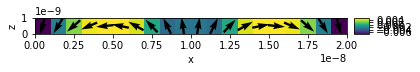

In [14]:
# insert missing code here.
system.hamiltonian = oc.Exchange(A=A) + oc.DMI(crystalclass="cnv", D=D)

md = oc.MinDriver()  # create energy minimisation driver
md.drive(system)

system.m.plot_plane("y")

2018/07/09 20:38: Running OOMMF (exchange_and_DMI/exchange_and_DMI.mif) ... (1.6 s)


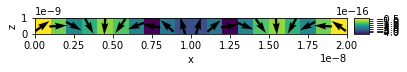

In [15]:
system.hamiltonian = oc.Exchange(A=A) + oc.DMI(crystalclass="cnv", D=2*D)
system.m.value = (0, 1, 1)
md.drive(system)
system.m.plot_plane("y")